# Init project 

In [1]:
import herepy

import folium
import pygal
import pandas as pd

import numpy as np
import os
import re
import time 
import json
import datetime

from pyspark.sql import SQLContext
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
import findspark
findspark.init()

import pyspark
import random
import math

# sc.stop()
sc = pyspark.SparkContext(appName="Valeur Fonctiere")

# Create Data File

No need to run it if final data file provided // Take few minutes

In [3]:
class txt_reader_valeurs_foncieres():
    
    def __init__(self, full_path_name_txt):
        self.txt_paths=full_path_name_txt
        self.dataframes=self.fill_dataframes()
    
    def fill_dataframes(self):
        dataframes=list()
        for path in self.txt_paths:
            df=pd.read_csv(path,sep='|',low_memory=False)
            dataframes.append(df)
        return dataframes
    
    
    def get_columns(self):
        columns=None
        for df in self.dataframes:
            if columns is None:
                columns=df.columns
            else:
                if columns.all()!=df.columns.all():
                    print('TXT format columns not matching')

        return columns
    
    def combine_all_csv(self,columns_selected):
        df_joined=pd.DataFrame()
        for df in self.dataframes:
            df_joined=df_joined.append(df[columns_selected],ignore_index=True)
        df_joined.fillna(0, inplace=True)
        df_joined.to_csv("Valeurs foncières/Joined/valeurs_foncieres_joined.csv",index=False) 

    def retrieve_df(self,item_num):
        return self.dataframes[item_num]

In [4]:
txt_files=list()
directory='Valeurs foncières/'
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        txt_files.append(directory+ '/' +filename)
        
reader_txt=txt_reader_valeurs_foncieres(txt_files)


# We want to keep few columns for analysis:
#     - Date mutation
#     -'Valeur fonciere'
#     -'No voie'
#     -'Type de voie'
#     -'Code voie'
#     -'Voie'
#     -'Code postal'
#     -'Commune'
#     -'Code departement'
#     -'Code commune'
#     -'Surface reelle bati'
#     -'Nombre pieces principales'


columns=['Date mutation','Valeur fonciere','No voie','Type de voie','Code voie','Voie',
    'Code postal','Commune','Code departement','Code commune','Surface reelle bati',
    'Nombre pieces principales']
reader_txt.combine_all_csv(columns)

# Read final data file as pd

In [3]:
df=pd.read_csv('valeurs_foncieres_joined.csv',dtype=str,low_memory=False)

# Select only ile de france
df_IleDeFrance=df[df['Code postal'].str.contains('^75[0-9]{3}.',regex=True, na=False)]

In [4]:
list_arrondissements=df_IleDeFrance['Code postal'].unique()

In [5]:
df_IleDeFrance.head()

,Date mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Surface reelle bati,Nombre pieces principales
922095,16/01/2019,"650000,00",25.0,AV,3520,FERDINAND BUISSON,75016.0,BOULOGNE-BILLANCOURT,92,12,89.0,3.0
922162,24/01/2019,"503029,00",35.0,AV,3520,FERDINAND BUISSON,75016.0,BOULOGNE-BILLANCOURT,92,12,55.0,3.0
922283,24/01/2019,"791600,00",3.0,RUE,1480,DU CDT GUILBAUD A PARIS,75016.0,BOULOGNE-BILLANCOURT,92,12,90.0,4.0
922482,18/01/2019,"607600,00",20.0,RUE,6660,NUNGESSER ET COLI,75016.0,BOULOGNE-BILLANCOURT,92,12,66.0,3.0
924012,15/03/2019,"860000,00",30.0,RUE,6660,NUNGESSER ET COLI,75016.0,BOULOGNE-BILLANCOURT,92,12,105.0,3.0


In [6]:
df_IleDeFrance[df_IleDeFrance['Voie']=='DUPHOT']

,Date mutation,Valeur fonciere,No voie,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Surface reelle bati,Nombre pieces principales
995783,04/01/2019,"1196000,00",17.0,RUE,2999,DUPHOT,75001.0,PARIS 01,75,101,112.0,3.0
996804,12/04/2019,"2691110,00",15.0,RUE,2999,DUPHOT,75001.0,PARIS 01,75,101,160.0,0.0
996808,03/04/2019,"540500,00",10.0,RUE,2999,DUPHOT,75001.0,PARIS 01,75,101,43.0,2.0
996809,03/04/2019,"540500,00",10.0,RUE,2999,DUPHOT,75001.0,PARIS 01,75,101,45.0,2.0
996810,03/04/2019,"439500,00",10.0,RUE,2999,DUPHOT,75001.0,PARIS 01,75,101,37.0,0.0
996811,03/04/2019,"439500,00",10.0,RUE,2999,DUPHOT,75001.0,PARIS 01,75,101,43.0,2.0
997406,21/05/2019,"434000,00",19.0,RUE,2999,DUPHOT,75001.0,PARIS 01,75,101,92.0,0.0
997407,21/05/2019,"434000,00",19.0,RUE,2999,DUPHOT,75001.0,PARIS 01,75,101,0.0,0.0
997408,21/05/2019,"148000,00",19.0,RUE,2999,DUPHOT,75001.0,PARIS 01,75,101,91.0,0.0
4016535,29/06/2018,"50000,00",17.0,RUE,2999,DUPHOT,75001.0,PARIS 01,75,101,0.0,0.0


# Read final data file as RDD // pyspark

In [7]:
file_france = sc.textFile("valeurs_foncieres_joined.csv")

In [8]:
future_pattern = re.compile("""([^,"]+|"[^"]+")(?=,|$)""")

def parseCSV(line):
    return future_pattern.findall(line)

In [9]:
data_France = file_france.map(parseCSV).filter(lambda x: x[0]!="Date mutation")

In [10]:
iledefrance_pattern=re.compile("""^75[0-9]{3}..""")
data_IleDeFrance=data_France.filter(lambda x: iledefrance_pattern.findall(x[6]))

In [11]:
data_IleDeFrance_map=data_IleDeFrance.map(lambda x: ((x[2],x[3],x[5],x[7],x[6]),(x[0],float(x[1].replace("\"","").replace(",",".")),float(x[10])))).filter(lambda x: x[1][2]!='0.0')

In [12]:
data_IleDeFrance_map.cache().count()

146878

In [13]:
data_IleDeFrance_map.take(5)

[(('25.0', 'AV', 'FERDINAND BUISSON', 'BOULOGNE-BILLANCOURT', '75016.0'),
  ('16/01/2019', 650000.0, 89.0)),
 (('35.0', 'AV', 'FERDINAND BUISSON', 'BOULOGNE-BILLANCOURT', '75016.0'),
  ('24/01/2019', 503029.0, 55.0)),
 (('3.0', 'RUE', 'DU CDT GUILBAUD A PARIS', 'BOULOGNE-BILLANCOURT', '75016.0'),
  ('24/01/2019', 791600.0, 90.0)),
 (('20.0', 'RUE', 'NUNGESSER ET COLI', 'BOULOGNE-BILLANCOURT', '75016.0'),
  ('18/01/2019', 607600.0, 66.0)),
 (('30.0', 'RUE', 'NUNGESSER ET COLI', 'BOULOGNE-BILLANCOURT', '75016.0'),
  ('15/03/2019', 860000.0, 105.0))]

In [14]:
list_arrondissements=df_IleDeFrance['Code postal'].unique()

In [15]:
for arrondissement in list_arrondissements:
    data_arrondissement=data_IleDeFrance_map.filter(lambda x: arrondissement==x[0][4])
    print(arrondissement, ' : ',data_arrondissement.count())

75016.0  :  15455
75015.0  :  9254
75001.0  :  1730
75003.0  :  3226
75008.0  :  5611
75006.0  :  3569
75007.0  :  4554
75005.0  :  3239
75009.0  :  5966
75010.0  :  7957
75011.0  :  9275
75012.0  :  6953
75013.0  :  6936
75014.0  :  8904
75017.0  :  13760
75018.0  :  15296
75020.0  :  9201
75019.0  :  10522
75004.0  :  2843
75002.0  :  2627


# Get long/lat from address with GeocoderApi

### Test on single request

In [18]:
# API init with Key
geocoderApi = herepy.GeocoderApi('8UDt2_0vw7gJ2ffM2I2I17GIzMz5e8H980InYedeLcU')

# s5tGP7hB1Md6T9HzvUm72xqF87Dur5vE119ARWilHPk    // guillaume_lehericy@hotmail.fr
# 8UDt2_0vw7gJ2ffM2I2I17GIzMz5e8H980InYedeLcU

In [19]:
arron='75016.0'
# test_arron.unpersist()
test_arron=data_IleDeFrance_map.filter(lambda x: arron==x[0][4])
test_arron.cache().count()

15455

In [20]:
first_item=test_arron.take(1)
first_item

[(('25.0', 'AV', 'FERDINAND BUISSON', 'BOULOGNE-BILLANCOURT', '75016.0'),
  ('16/01/2019', 650000.0, 89.0))]

### If request correct

In [21]:
response = geocoderApi.address_with_details(first_item[0][0][0],first_item[0][0][2] ,first_item[0][0][3],'France')
print(response)

{"Response": {"MetaInfo": {"Timestamp": "2020-01-10T13:04:40.340+0000"}, "View": [{"Result": [{"Location": {"Address": {"AdditionalData": [{"key": "CountryName", "value": "France"}, {"key": "StateName", "value": "\u00cele-de-France"}, {"key": "CountyName", "value": "Hauts-de-Seine"}], "City": "Boulogne-Billancourt", "Country": "FRA", "County": "Hauts-de-Seine", "HouseNumber": "25", "Label": "25 Avenue Ferdinand Buisson, 92100 Boulogne-Billancourt, France", "PostalCode": "92100", "State": "\u00cele-de-France", "Street": "Avenue Ferdinand Buisson"}, "DisplayPosition": {"Latitude": 48.8372, "Longitude": 2.2531}, "LocationId": "NT_Vg-CxxRerWzRR2eTu5a.jA_yUD", "LocationType": "point", "MapView": {"BottomRight": {"Latitude": 48.8360758, "Longitude": 2.2548079}, "TopLeft": {"Latitude": 48.8383242, "Longitude": 2.2513921}}, "NavigationPosition": [{"Latitude": 48.83725, "Longitude": 2.25324}]}, "MatchLevel": "houseNumber", "MatchQuality": {"City": 1.0, "Country": 1.0, "HouseNumber": 1.0, "Stree

### If request wrong (no return)

In [22]:
response = geocoderApi.address_with_details(first_item[0][0][0],first_item[0][0][2] ,'random','France')
print(response)

{"Response": {"MetaInfo": {"Timestamp": "2020-01-12T15:43:24.140+0000"}, "View": []}}


#### We had to identify both cases in order to deal with missing info

# Retrieve all coord for items in Ile de France

In [23]:
# Request api for each rows in RDD
def geoLoca(x):
    return x[0][0],x[0][1],x[0][2],x[0][3],x[0][4], x[1][0], x[1][1], x[1][2], geocoderApi.address_with_details(x[0][0],x[0][2] ,x[0][3],'France').as_dict()

# Retrieve only Lat and Long from API response
def getOnlyLatLong(x):
    try:
        lat=x[8]['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude']
        long=x[8]['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude']
        return x[0], x[1], x[2], x[3],x[4],x[5],x[6],x[7],lat,long
    except:
        try:
            return x[0], x[1], x[2], x[3],x[4],x[5],x[6],x[7],0,0
        except:
            return x


In [24]:
# for each 'arrondissement', request API (high chances to crash if all requested at once so we divided the work in order to not start from scratch if error / take a long time to run)
for arrondissement in list_arrondissements:
    if not os.path.exists('arrondissement/' + arrondissement):
        start=time.process_time()
        print(arrondissement, ' , ', data_IleDeFrance_map.filter(lambda x: arrondissement==x[0][4]).count(), time.localtime())
        data_arrondissement=data_IleDeFrance_map.filter(lambda x: arrondissement==x[0][4])
        data_geo=data_arrondissement.map(lambda x: geoLoca(x)).map(lambda x: getOnlyLatLong(x))
        data_geo.cache().collect()
        data_geo.saveAsTextFile('arrondissement/' + arrondissement)
        print(arrondissement, ' , ', data_geo.count(),' : ', time.process_time()-start)

75011.0  ,  9275 time.struct_time(tm_year=2020, tm_mon=1, tm_mday=12, tm_hour=20, tm_min=25, tm_sec=21, tm_wday=6, tm_yday=12, tm_isdst=0)
75011.0  ,  9275  :  0.1318980000000014
75012.0  ,  6953 time.struct_time(tm_year=2020, tm_mon=1, tm_mday=12, tm_hour=20, tm_min=39, tm_sec=19, tm_wday=6, tm_yday=12, tm_isdst=0)
75012.0  ,  6953  :  0.11816866100000034
75013.0  ,  6936 time.struct_time(tm_year=2020, tm_mon=1, tm_mday=12, tm_hour=20, tm_min=50, tm_sec=36, tm_wday=6, tm_yday=12, tm_isdst=0)
75013.0  ,  6936  :  0.10023059000000067
75014.0  ,  8904 time.struct_time(tm_year=2020, tm_mon=1, tm_mday=12, tm_hour=21, tm_min=0, tm_sec=53, tm_wday=6, tm_yday=12, tm_isdst=0)
75014.0  ,  8904  :  0.14788003900000035
75017.0  ,  13760 time.struct_time(tm_year=2020, tm_mon=1, tm_mday=12, tm_hour=21, tm_min=15, tm_sec=50, tm_wday=6, tm_yday=12, tm_isdst=0)
75017.0  ,  13760  :  0.2134044700000004
75018.0  ,  15296 time.struct_time(tm_year=2020, tm_mon=1, tm_mday=12, tm_hour=21, tm_min=38, tm_sec=

# Read saved files of all 'arrondissement'

In [20]:
# retrieve all folders in 'arrondissement' and then read them
list_arrondissement_path=list()
for item in os.listdir('arrondissement'):
    list_arrondissement_path.append('arrondissement/'+item)
data=sc.textFile(','.join(list_arrondissement_path))

In [21]:
data=data.map(parseCSV)

In [22]:
# read json polygons 
with open('quartier_paris.geojson') as json_file:
    quartier_info = json.load(json_file)

# check if localisation belongs to one of the polygons
def returnQuartier(x):
    list_return=list()
    for item in x:
        list_return.append(item.replace('(', '').replace(')', '').replace("'","").replace(' ',''))
    for neighbor in quartier_info['features']:
        polygon = Polygon(neighbor['geometry']['coordinates'][0]) # create polygon
        point = Point(float(x[9].replace(' ','').replace(')','')),float(x[8].replace(' ','')))
        if polygon.contains(point):
            list_return.append(neighbor['properties']['l_qu'])
            return list_return
    list_return.append('NaN')
    return list_return

In [23]:
with_neigbhor=data.map(lambda x: returnQuartier(x))
with_neigbhor.take(2)

[['32.0',
  'RUE',
  'SAUSSURE',
  'PARIS17',
  '75017.0',
  '09/01/2017',
  '571000.0',
  '59.0',
  '48.88446',
  '2.31607',
  'Batignolles'],
 ['171.0',
  'RUE',
  'LEGENDRE',
  'PARIS17',
  '75017.0',
  '06/01/2017',
  '210000.0',
  '30.0',
  '48.89153',
  '2.32563',
  'Epinettes']]

In [24]:
test=data.map(lambda x: returnQuartier(x)).map(lambda x: returnQuartier(x)).filter(lambda x: float(x[6])!=0 and float(x[7])!=0).map(lambda x: (str(datetime.datetime.strptime(x[5], "%d/%m/%Y").month) + '/' + str(datetime.datetime.strptime(x[5], "%d/%m/%Y").year),float(x[6])/float(x[7])))
test.take(3)

[('1/2017', 9677.966101694916),
 ('1/2017', 7000.0),
 ('1/2017', 7272.727272727273)]

In [25]:
sum_neigbhor=data.map(lambda x: returnQuartier(x)).filter(lambda x: float(x[6])!=0 and float(x[7])!=0).map(lambda x: (x[10],(float(x[6]),float(x[7]),1))).reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1],x[2]+y[2]))
sum_neigbhor.collect()
# Col1 = Quartier ; Col2 = Prix total desz ventes dans le quartier ; Col3= nombre de ventes

[('Saint-Gervais', (1022177282.2, 39336.0, 758)),
 ('Batignolles', (4172587815.63, 157231.0, 2685)),
 ('Gare', (2530983561.4700003, 109291.0, 1380)),
 ('La Chapelle', (3267770059.73, 81298.0, 1227)),
 ('Pont-de-Flandre', (1210814087.4599998, 63560.0, 852)),
 ('Saint-Vincent-de-Paul', (677408867.99, 58752.0, 1001)),
 ('Auteuil', (3160521035.91, 252718.0, 3543)),
 ('Petit-Montrouge', (1330424707.3599997, 112280.0, 1943)),
 ('Europe', (8489775462.81, 159125.0, 1365)),
 ('Sainte-Marguerite', (1121258575.27, 67488.0, 1256)),
 ('Montparnasse', (2088615716.76, 67485.0, 1077)),
 ('Clignancourt', (4251286244.829999, 251958.0, 5052)),
 ('Père-Lachaise', (973676046.46, 86413.0, 1824)),
 ('Mail', (4077192480.8199997, 78994.0, 799)),
 ('Arts-et-Métiers', (591727724.05, 56305.0, 1073)),
 ('Grenelle', (2138371131.79, 113073.0, 1584)),
 ('Notre-Dame', (436979203.0, 19160.0, 262)),
 ('Madeleine', (3887107943.6, 81555.0, 728)),
 ('Place-Vendôme', (4156316156.12, 39770.0, 289)),
 ('Sorbonne', (868185387.

In [26]:
mean_price_per_neigbors=sum_neigbhor.map(lambda x: (x[0],x[1][0]/x[1][2],x[1][0]/x[1][1],x[1][2]))
mean_price_per_neigbors.collect()
# Col1 = Quartier ; Col2 = Prix moyen ; Col3 = Prix m2 : Col4= nombre de ventes

[('Saint-Gervais', 1348518.8419525067, 25985.796273134027, 758),
 ('Batignolles', 1554036.4304022347, 26537.94617874338, 2685),
 ('Gare', 1834046.059036232, 23158.206636136554, 1380),
 ('La Chapelle', 2663219.282583537, 40194.96248038082, 1227),
 ('Pont-de-Flandre', 1421143.2951408448, 19049.9384433606, 852),
 ('Saint-Vincent-de-Paul', 676732.1358541459, 11529.971200810185, 1001),
 ('Auteuil', 892046.5808382726, 12506.117632736885, 3543),
 ('Petit-Montrouge', 684727.0753268141, 11849.169107231917, 1943),
 ('Europe', 6219615.72367033, 53352.87015120189, 1365),
 ('Sainte-Marguerite', 892721.7955971337, 16614.19178624348, 1256),
 ('Montparnasse', 1939290.359108635, 30949.332692598357, 1077),
 ('Clignancourt', 841505.5908214566, 16872.99567717635, 5052),
 ('Père-Lachaise', 533813.6219627194, 11267.70331385324, 1824),
 ('Mail', 5102869.187509387, 51613.95144973035, 799),
 ('Arts-et-Métiers', 551470.3858807082, 10509.328195542135, 1073),
 ('Grenelle', 1349981.7751199494, 18911.421221600205, 

# Analysis

In [17]:
sqlContext = SQLContext(sc)

## Prix d'un quartier en fonction de sa taille en m2

In [27]:
rdd = sqlContext.createDataFrame(with_neigbhor)
df=rdd.toPandas()

In [28]:
df.columns=['Num','Type','Adr','Zone','Code','Date','Prix','m2','Lat','Long','Quartier']

In [29]:
df_pandas=df

In [30]:
df_pandas['Prix']=df_pandas['Prix'].astype(float)
df_pandas['m2']=df_pandas['m2'].astype(float)
df_pandas['Date']=pd.to_datetime(df['Date'], format="%d/%m/%Y")
df_pandas=df_pandas[df_pandas['Prix']!=0]
df_pandas=df_pandas[df_pandas['m2']!=0]
df_pandas["price_m2"]=df_pandas["Prix"]/df_pandas["m2"]

In [31]:
df_pandas.head()

,Num,Type,Adr,Zone,Code,Date,Prix,m2,Lat,Long,Quartier,price_m2
0,32.0,RUE,SAUSSURE,PARIS17,75017.0,2017-01-09,571000.0,59.0,48.88446,2.31607,Batignolles,9677.966102
1,171.0,RUE,LEGENDRE,PARIS17,75017.0,2017-01-06,210000.0,30.0,48.89153,2.32563,Epinettes,7000.000000
3,46.0,RUE,DESMOINES,PARIS17,75017.0,2017-01-06,160000.0,22.0,48.8896,2.32024,Epinettes,7272.727273
6,37.0,RUE,POUCHET,PARIS17,75017.0,2017-01-02,179000.0,24.0,48.89341,2.31984,Epinettes,7458.333333
7,6.0,RUE,DEODATDESEVERAC,PARIS17,75017.0,2017-01-11,225000.0,30.0,48.88593,2.31046,Batignolles,7500.000000


In [32]:
df_quantile=df_pandas

In [33]:
quantile_m2= df["m2"].quantile(0.80)
quantile_Prix= df["Prix"].quantile(0.80)
df_quantile=df_quantile[df_pandas["Prix"]<quantile_Prix]
df_quantile=df_quantile[df_pandas["m2"]<quantile_m2]

/home/guillaume/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [272]:
quartier='Maison-Blanche'
df_quartier=df_quantile[df_quantile['Quartier']==quartier]

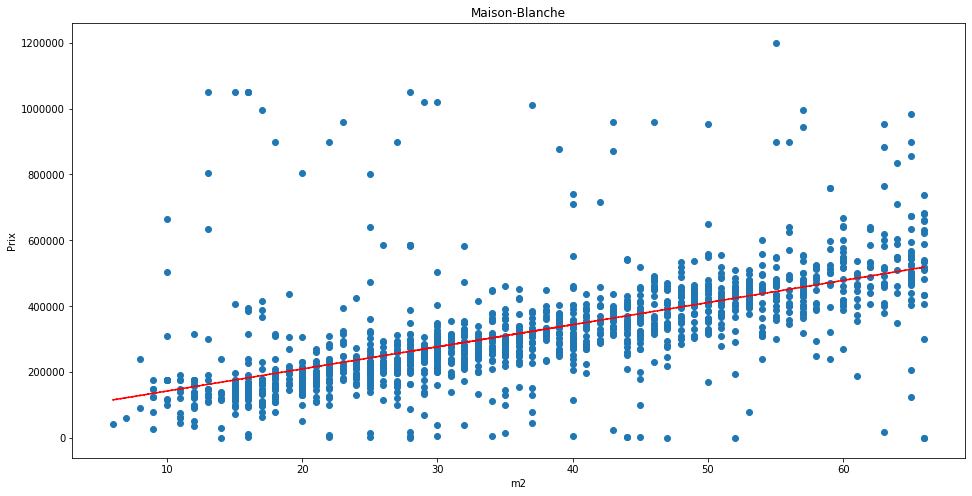

In [293]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x=df_quartier['m2'],y=df_quartier['Prix'])
ax.set_xlabel('m2')
ax.set_ylabel('Prix')

z = np.polyfit(df_quartier['m2'], df_quartier['Prix'], 1)
p = np.poly1d(z)

ax.plot(df_quartier['m2'],p(df_quartier['m2']),"r--")

plt.title(quartier)
plt.show()

## Evolution des prix a Paris? 2017-2018

In [294]:
df_quantile=df_quantile.sort_values(by=['Date'])
df_quantile['Month']=pd.DatetimeIndex(df_quantile['Date']).month
df_quantile['Year']=pd.DatetimeIndex(df_quantile['Date']).year
df_quantile['Month/Year']=df_quantile['Month'].map(str) + '/' + df_quantile['Year'].map(str)
df_quantile['Month/Year']=pd.to_datetime(df_quantile['Month/Year'], format="%m/%Y")

In [263]:
df_quantile=df_quantile.sort_values(by=['Month/Year'])
df_quantile

,Num,Type,Adr,Zone,Code,Date,Prix,m2,Lat,Long,Quartier,price_m2,Month,Year,Month/Year
27716,13.0,RUE,LOUISBRAILLE,PARIS12,75012.0,2017-01-02,193300.0,28.0,48.83979,2.40189,Bel-Air,6903.571429,1,2017,2017-01-01
27982,91.0,RUE,DEREUILLY,PARIS12,75012.0,2017-01-23,371000.0,30.0,48.84447,2.39012,Picpus,12366.666667,1,2017,2017-01-01
89574,5.0,PL,DESTERNES,PARIS17,75017.0,2017-01-23,60000.0,9.0,48.8784,2.29765,Ternes,6666.666667,1,2017,2017-01-01
55456,5.0,RUE,LITTRE,PARIS06,75006.0,2017-01-24,214000.0,20.0,48.84576,2.32391,Notre-Dame-des-Champs,10700.000000,1,2017,2017-01-01
50476,19.0,RUE,DERICHEMONT,PARIS13,75013.0,2017-01-24,85000.0,15.0,48.82783,2.3694,Gare,5666.666667,1,2017,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138884,58.0,RUE,DELACHAUSS.DANTIN,PARIS09,75009.0,2019-06-12,1.0,10.0,48.87463,2.33268,Chaussée-d'Antin,0.100000,6,2019,2019-06-01
138882,58.0,RUE,DELACHAUSS.DANTIN,PARIS09,75009.0,2019-06-12,1.0,10.0,48.87463,2.33268,Chaussée-d'Antin,0.100000,6,2019,2019-06-01
138881,58.0,RUE,DELACHAUSS.DANTIN,PARIS09,75009.0,2019-06-12,1.0,10.0,48.87463,2.33268,Chaussée-d'Antin,0.100000,6,2019,2019-06-01
89063,39.0,RUE,LAUGIER,PARIS17,75017.0,2019-06-12,287500.0,29.0,48.88188,2.29474,Ternes,9913.793103,6,2019,2019-06-01


In [264]:
df_final=df_quantile.groupby(['Month/Year']).mean().reset_index()

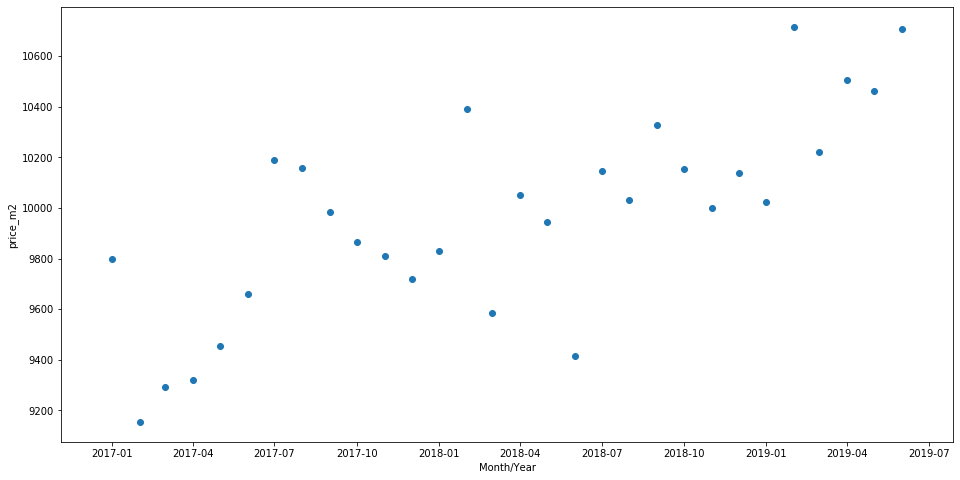

In [265]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(x=df_final['Month/Year'],y=df_final['price_m2'])
ax.set_xlabel('Month/Year')
ax.set_ylabel('price_m2')

plt.show()

### On remarque une tendance haussière sur les prix en fonction du temps

# Folium map

#### Colore les quartiers en fonction du prix moyen au m2 

In [39]:
import folium #mappingas
import branca.colormap as cm

In [35]:
df_mean_quartier=df_quantile.groupby(['Quartier']).mean().reset_index()

In [37]:
print(df_mean_quartier[df_mean_quartier['Quartier']=='Sorbonne']['price_m2'].min())
print(df_mean_quartier[df_mean_quartier['Quartier']=='Sorbonne']['price_m2'].max())

13837.179534327366
13837.179534327366


In [40]:
coords = (48.864716,2.349014)
map = folium.Map(location=coords, tiles='OpenStreetMap', zoom_start=12)

linear = cm.LinearColormap(
    ['green','yellow', 'red'],
    vmin=df_mean_quartier['price_m2'].min(), vmax=df_mean_quartier['price_m2'].max()
)

#style function

def style_function(feature):
    if df_mean_quartier['Quartier'].isin([feature['properties']['l_qu']]).any().any():
        value=df_mean_quartier.loc[df_mean_quartier['Quartier'] == feature['properties']['l_qu'], 'price_m2'].iloc[0] 
        return {
            'fillColor': linear(value),
            'fillOpacity': 0.5,
            'color': 'black',
            'weight': 1,
            'dashArray': '5, 5'
        }
    return {
        'fillColor': linear(0),
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
        }
folium.GeoJson(
    data=quartier_info,
    name=quartier_info,
    style_function= style_function
).add_to(map)


map.save(outfile='map.html')

from IPython.display import IFrame
IFrame(src='map.html', width=900, height=600)

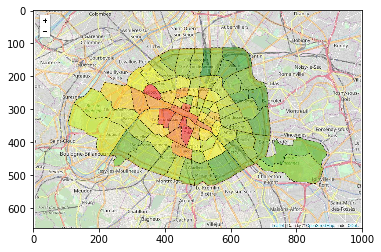

In [43]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('Map.jpg')
imgplot = plt.imshow(img)
plt.show()